In [1]:
import time
start_time=time.time()

In [66]:
#from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import interpolate
import numpy as np
import pandas as pd
import json
import itertools

from astropy.io import fits
import astropy.units as u
#from astropy.table import Table

import turbustat.statistics as tss

import statsmodels.api as sm
#from scipy.fftpack import fft
#import math
#import sys
#import os
#from PIL import Image

from sabreMod import sosf
import strucfunc

Text(0.5, 1.0, 'H$_{α}$ Flux')

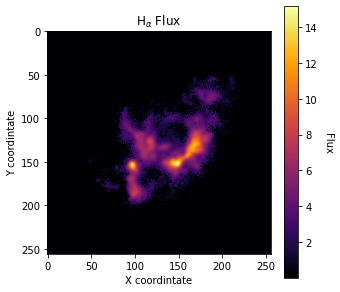

In [3]:
FitsFile= 'Obs/TAURUS.604.Ha.Flux'
hdul=fits.open(FitsFile + '.fits')
fig, ax = plt.subplots(figsize=(5, 5))
image_data=hdul[0].data
plt.imshow(image_data, cmap='inferno')
ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')
cbar = plt.colorbar()
cbar.set_label('Flux', rotation=270, labelpad=15)  
plt.title('H$_{α}$ Flux')

In [4]:
flx=hdul[0].data
df=pd.DataFrame(flx)
dffx=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'I'})
dffx.describe()

,X,Y,I
count,65536.000000,65536.000000,6.553600e+04
mean,127.500000,127.500000,5.889378e-01
std,73.900834,73.900834,1.665959e+00
min,0.000000,0.000000,3.787646e-09
25%,63.750000,63.750000,3.787646e-09
50%,127.500000,127.500000,3.787646e-09
75%,191.250000,191.250000,3.787646e-09
max,255.000000,255.000000,1.515018e+01


Text(0.5, 1.0, 'H$_{α}$ Radial Velocity')

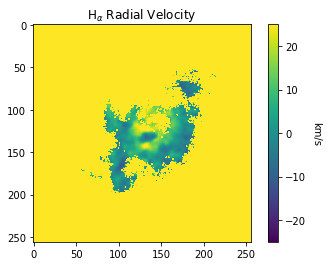

In [5]:
FitsFile= 'Obs/TAURUS.604.Ha.RV'
hdul=fits.open(FitsFile + '.fits')
image_data=hdul[0].data
plt.imshow(image_data, cmap='viridis')
ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')
cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  
plt.clim(-25,25) 
plt.title('H$_{α}$ Radial Velocity')

In [6]:
vel=hdul[0].data
df=pd.DataFrame(vel)
dfvr=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'RV'})
dfvr.describe()

,X,Y,RV
count,65536.000000,65536.000000,65536.000000
mean,127.500000,127.500000,335.500406
std,73.900834,73.900834,139.319611
min,0.000000,0.000000,-16.693176
25%,63.750000,63.750000,393.980011
50%,127.500000,127.500000,393.980011
75%,191.250000,191.250000,393.980011
max,255.000000,255.000000,393.980011


Text(0.5, 1.0, 'H$_{α}$ σ$_{disp}$')

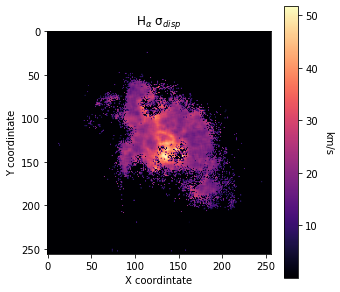

In [7]:
FitsFile= 'Obs/TAURUS.604.Ha.Sigma'
hdul=fits.open(FitsFile + '.fits')
fig, ax = plt.subplots(figsize=(5, 5))
image_data=hdul[0].data
plt.imshow(image_data, cmap='magma')
ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')
cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  
plt.title('H$_{α}$ σ$_{disp}$')

In [8]:
sig=hdul[0].data
df=pd.DataFrame(sig)
dsig=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'Sig'})
dsig.describe()

,X,Y,Sig
count,65536.000000,65536.000000,6.553600e+04
mean,127.500000,127.500000,3.607881e+00
std,73.900834,73.900834,8.906863e+00
min,0.000000,0.000000,1.291134e-08
25%,63.750000,63.750000,1.291134e-08
50%,127.500000,127.500000,1.291134e-08
75%,191.250000,191.250000,1.291134e-08
max,255.000000,255.000000,5.164933e+01


In [9]:
data=dfvr
data['I']=dffx.I
data['Sig']=dsig.Sig
data.describe()

,X,Y,RV,I,Sig
count,65536.000000,65536.000000,65536.000000,6.553600e+04,6.553600e+04
mean,127.500000,127.500000,335.500406,5.889378e-01,3.607881e+00
std,73.900834,73.900834,139.319611,1.665959e+00,8.906863e+00
min,0.000000,0.000000,-16.693176,3.787646e-09,1.291134e-08
25%,63.750000,63.750000,393.980011,3.787646e-09,1.291134e-08
50%,127.500000,127.500000,393.980011,3.787646e-09,1.291134e-08
75%,191.250000,191.250000,393.980011,3.787646e-09,1.291134e-08
max,255.000000,255.000000,393.980011,1.515018e+01,5.164933e+01


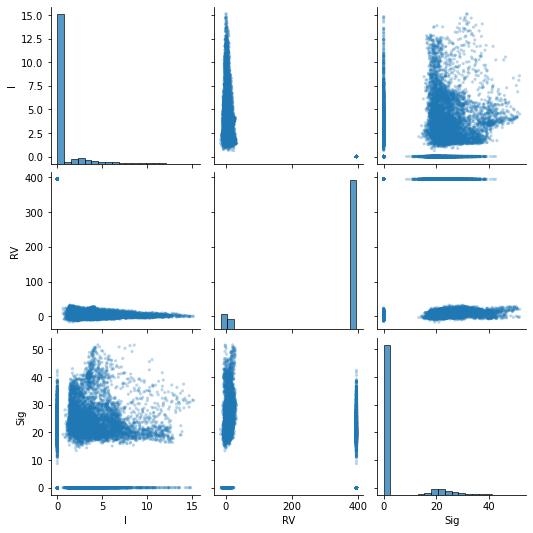

In [10]:
sns.pairplot(data, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

In [11]:
mI=(data.I>data.I.mean()+0.5*data.I.std())&(data.Sig>data.Sig.mean()+0.5*data.Sig.std())
data=data[mI]

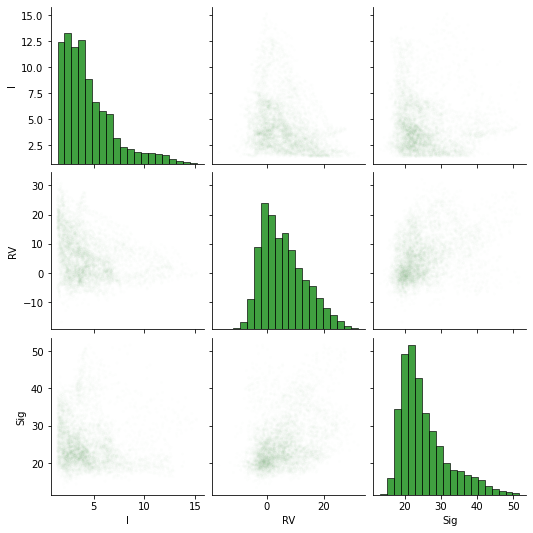

In [12]:
sns.pairplot(data, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.009, s=10, edgecolor='none',color='green'),
             diag_kws=dict(bins=20, color="green"),
            )

In [13]:
data.describe()

,X,Y,RV,I,Sig
count,5525.000000,5525.000000,5525.000000,5525.000000,5525.000000
mean,127.926878,138.877285,5.788416,4.452780,25.389558
std,20.598918,29.017395,7.674014,2.516801,6.638897
min,72.000000,69.000000,-16.693176,1.422287,13.366940
25%,111.000000,115.000000,-0.265381,2.589201,20.630642
50%,128.000000,139.000000,4.600464,3.794132,23.489672
75%,145.000000,165.000000,10.693939,5.609429,28.398582
max,194.000000,199.000000,32.009949,15.150179,51.649326


In [14]:
data.sem()

X      0.277127
Y      0.390384
RV     0.103242
I      0.033860
Sig    0.089316
dtype: float64

Text(0.5, 1.0, 'H$_{α}$ Flux')

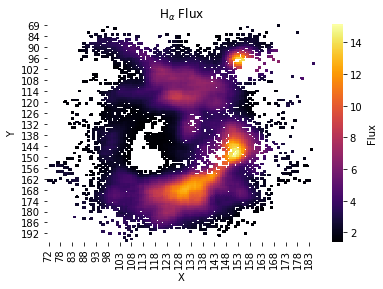

In [15]:
datal=data.copy()
#datal.I=np.log10(datal.I)
datal.X=datal.X.astype(int)
dataH_f=(datal.round(2)).pivot(index='Y', columns='X', values='I')
sns.heatmap(dataH_f, cmap="inferno",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.title('H$_{α}$ Flux')

Text(0.32, 0.9, '60 pc')

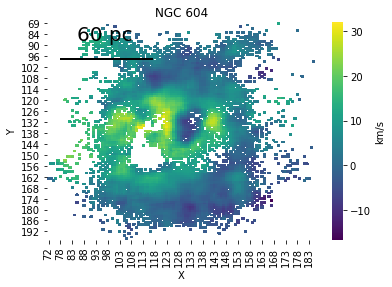

In [16]:

fig = plt.figure()
ax = fig.add_subplot()

datal=data.copy()

dataH_rv=(datal.round(2)).pivot(index='Y', columns='X', values='RV')
sns.heatmap(dataH_rv, cmap="viridis",cbar_kws={'label': 'km/s'})
plt.title('NGC 604')

plt.axhline(y=20, xmin=0.05, xmax=0.39, linewidth=2, color = 'k')

ax.text(0.32, 0.9, '60 pc',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=20)


Text(0.5, 1.0, 'H$_{α}$ σ$_{disp}$')

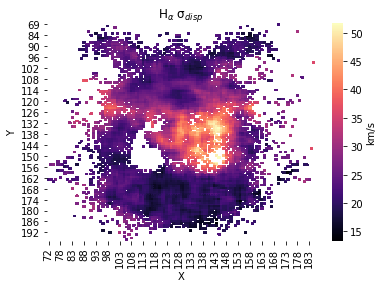

In [17]:
datal=data.copy()
dataH_s=(datal.round(2)).pivot(index='Y', columns='X', values='Sig')
sns.heatmap(dataH_s, cmap="magma",cbar_kws={'label': 'km/s'})
plt.title('H$_{α}$ σ$_{disp}$')
#plt.savefig('TAURUS/Imgs/A/'+reg+'SH.png')

In [18]:
#data.Sig

In [19]:
data.Sig=(data.Sig**2-9.87**2-1.73**2)**0.5

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


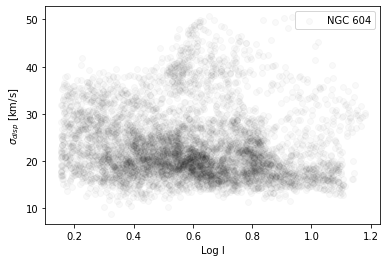

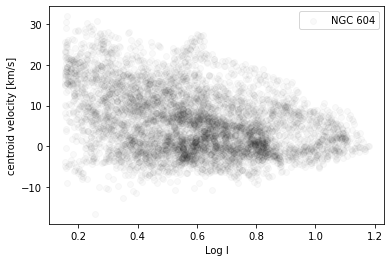

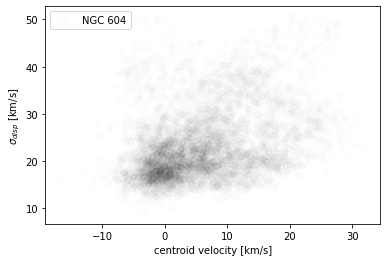

In [20]:
fig, ax = plt.subplots()
plt.scatter(np.log10(data.I),data.Sig, alpha=0.025, color='k',label='NGC 604')

ax.set_xlabel('Log I')
ax.set_ylabel('$σ_{disp}$ [km/s]')
plt.legend()

fig, ax = plt.subplots()
plt.scatter(np.log10(data.I),data.RV, alpha=0.025, color='k',label='NGC 604')

ax.set_xlabel('Log I')
ax.set_ylabel('centroid velocity [km/s]')
plt.legend()

fig, ax = plt.subplots()
plt.scatter(data.RV,data.Sig, alpha=0.008, color='k',label='NGC 604')

ax.set_xlabel('centroid velocity [km/s]')
ax.set_ylabel('$σ_{disp}$ [km/s]')
plt.legend()



Structure Function

phd

In [21]:
pc=1.05

1.0


[None, None]

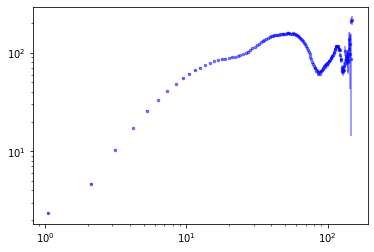

In [22]:
SF=sosf(data)
SF.Lag=SF.Lag*pc

fig,ax=plt.subplots()

ax.errorbar(SF.Lag,SF.Nmqvd, yerr=SF.ErrY, marker='.', fmt=' ',color="blue", ecolor="blue",
                     alpha=0.5, markersize=5)

ax.set(xscale='log',yscale='log')

In [23]:
df = SF[['Lag', 'Nmqvd']].copy()
df=df.rename(columns={"Lag": "pc", "Nmqvd": "S"})
df.to_csv('604.csv',mode = 'w', index=False)

In [24]:
x=SF['Lag']
y=SF['Nmqvd']-(data["RV"].std())**2
tck=interpolate.splrep(x,y,s=0)
grid=np.linspace(x.min(),x.max(),num=len(x))
ynew=interpolate.splev(grid,tck,der=0)
inter=pd.DataFrame([grid,ynew]).T
SFr=interpolate.sproot(tck)
SFr

array([10.05452091])

In [25]:
s=SFr[0]

In [26]:
ss=np.round((data['RV'].std())**2,2)

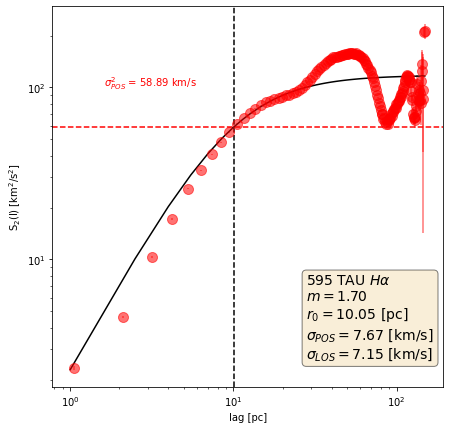

In [27]:
fig,ax=plt.subplots(figsize=(7,7))

ax.errorbar(SF.Lag,SF.Nmqvd, yerr=SF.ErrY, marker='.', fmt=' ',color="red", ecolor="red",
                     alpha=0.55, markersize=20)

ax.set(xlabel='lag [pc]', ylabel='S$_{2}$(l) [km$^{2}$/s$^{2}$]')

plt.axhline(y=ss, color='r', linestyle='--')
ax.text(0.25, 0.8,'$σ_{POS}^{2}$ = '+str(ss)+' km/s', ha='center', va='center', transform=ax.transAxes, color='r')


plt.axvline(x=s, color='k', linestyle='--')

lo=s

n=1.7

x=np.linspace(int(SF.Lag.min()),int(SF.Lag.max()),100)
c=1/(1+(x/lo)**n)

y=2*(1-c)*ss

plt.loglog(x,y,color='k', linestyle='-')


textstr = '\n'.join(('595 TAU ' r'$Hα$' ,r'$m=%.2f$'%n, r'$r_{0}=%.2f$' % s+' [pc]',
                     r'$σ_{POS}=%.2f$' % (data["RV"].std()) + ' [km/s]' , r'$σ_{LOS}=%.2f$'%(data["Sig"].std()) + ' [km/s]' )) 

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.65, .3, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="20"

#ax.set_xlim(1, 250)
#ax.set_ylim(1, 750)

#fig.savefig('Img//'+samples[0][i]+'.pdf')

Dr. Will

In [28]:
sb=np.array(dataH_f)

In [29]:
vv=np.array(dataH_rv)

In [30]:
ss=np.array(dataH_s)

In [31]:
# Replace spurious values in the arrays
m = ~np.isfinite(sb*vv*ss) | (sb < 0.0)
sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

<ipython-input-31-d66c5605846e>:2: RuntimeWarning: invalid value encountered in less
  m = ~np.isfinite(sb*vv*ss) | (sb < 0.0)


In [32]:
rslt = strucfunc.strucfunc_numba_parallel(vv, wmap=sb, dlogr=0.15)

In [33]:
good = (~m) & (sb > 0.001)
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [34]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [35]:
jsonfilename = "604sfh.json"
with open(jsonfilename, "w") as f:
    json.dump(rslt, fp=f, indent=3, cls=MyEncoder)
print(jsonfilename, end="")

604sfh.json

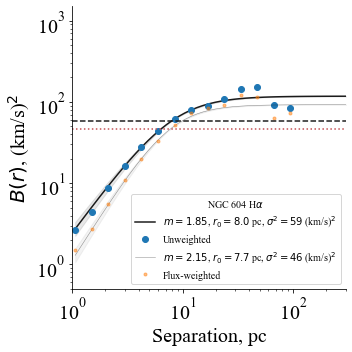

In [36]:
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def bfunc(r, r0, sig2, m):
    "Theoretical structure function"
    C = 1.0 / (1.0 + (r/r0)**m)
    return 2.0*sig2*(1 - C)

data = json.load(open("604sfh.json"))

sns.set_color_codes()
fig, ax = plt.subplots(figsize=(5, 5))

figfile = "604.pdf"

pixscale = 0.26 # arcsec
pixscale *= 4.09              # parsec
r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]
B_w = np.array(data["Weighted B(r)"])
sig2_w = data["Weighted sigma^2"]

# Plot fit to unweighted strucfunc
rgrid = pixscale * np.logspace(0.0, 2.7)
r0 = np.interp(sig2, B, r)
m = 1.85
flabel = rf"$m = {m:.2f}$, $r_0 = {r0:.1f}$ pc, $\sigma^2 = {sig2:.0f}$ (km/s)$^2$"
ax.fill_between(
    rgrid,
    bfunc(rgrid, r0, sig2, m - 0.1),
    bfunc(rgrid, r0, sig2, m + 0.1),
    color="k", alpha=0.1,
)
ax.plot(rgrid, bfunc(rgrid, r0, sig2, m), color="k", label=flabel)

# Plot points from unweighted strucfunc
ax.plot(r, B, 'o', label="Unweighted")


# Plot fit to weighted strucfunc
r0_w = np.interp(sig2_w, B_w, r)
m_w = 2.15
flabel_w = rf"$m = {m_w:.2f}$, $r_0 = {r0_w:.1f}$ pc, $\sigma^2 = {sig2_w:.0f}$ (km/s)$^2$"
ax.fill_between(
    rgrid,
    bfunc(rgrid, r0_w, sig2_w, m_w - 0.1),
    bfunc(rgrid, r0_w, sig2_w, m_w + 0.1),
    color="k", alpha=0.05,
)
ax.plot(rgrid, bfunc(rgrid, r0_w, sig2_w, m_w), lw=0.5, color="k", alpha=0.5, label=flabel_w)

# Plot points from weighted strucfunc
ax.plot(r, B_w, 'o', ms=3, alpha=0.5, label="Flux-weighted")


#melnick_r = np.array([2.5, 7.5, 12.5, 17.5, 22.5, 27.5])
#melnick_B = np.array([2.0, 2.1, 2.2, 2.2, 2.25, 2.25]) * 18.2**2
#ax.plot(melnick_r, melnick_B, 's', label="Melnick+ (2020)", color="y", zorder=-10)

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="10"

ax.axhline(sig2, color="k", ls="--")
ax.axhline(sig2_w, color="r", ls=":")
ax.legend(title=r"NGC 604 H$\alpha$")
ax.set(
    xscale = "log",
    yscale = "log",
    ylim  = [0.5, 1500],
    xlim  = [1, 300],
    xlabel = "Separation, pc",
    ylabel = r"$B(r)$, (km/s)$^2$",
)
fig.tight_layout()
sns.despine()
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))

Delta Variance

In [37]:
hdul = fits.open('Obs/604RV.fits')
vmed = np.nanmedian(hdul[0].data)
m = np.isfinite(hdul[0].data)
hdul[0].data[~m] = vmed

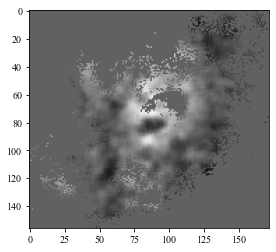

In [38]:
plt.imshow(hdul[0].data, cmap='gray')

In [39]:
dvar = tss.DeltaVariance(hdul[0])

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.924
Model:                            WLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     92.25
Date:                Wed, 05 May 2021   Prob (F-statistic):           2.87e-07
Time:                        10:08:52   Log-Likelihood:                 20.294
No. Observations:                  15   AIC:                            -36.59
Df Residuals:                      13   BIC:                            -35.17
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7535      0.048    -15.552      0.0

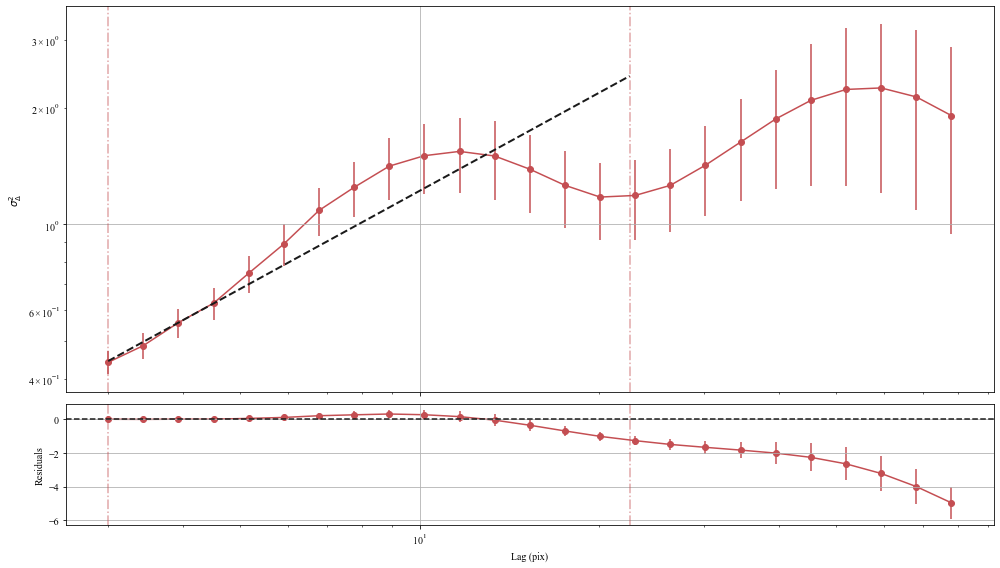

In [40]:
plt.figure(figsize=(14, 8))
dvar.run(verbose=True, boundary="fill",xlow=3*u.pix, xhigh=22.5*u.pix,)

In [41]:
preData='DT//pre604SF.csv'
dtx=pd.read_csv(preData)
dtx['pc.1']=dtx['pc.1'].replace(['0',0], np.nan)
dtx.describe()

,pc,S,pc.1,S.1
count,44.000000,44.000000,35.000000,44.000000
mean,45.366818,81.154318,47.322000,76.617045
std,38.343820,40.850735,33.029732,52.164418
min,1.420000,2.140000,1.170000,0.000000
25%,16.477500,52.480000,21.310000,22.095000
50%,32.025000,80.885000,41.130000,95.315000
75%,67.945000,115.767500,67.030000,115.730000
max,143.130000,140.260000,118.050000,173.650000


In [42]:
I0='DT//18a.csv'
I=pd.read_csv(I0)
I.describe()

,pc,S
count,23.000000,23.000000
mean,66.712834,111.712296
std,37.701983,52.002110
min,5.574400,29.956591
25%,35.995951,61.402927
50%,66.712199,109.693703
75%,97.519900,160.890302
max,128.119923,185.366035


In [43]:
T0='604.csv'
T=pd.read_csv(T0)
T.describe()

,pc,S
count,141.000000,141.000000
mean,74.551728,100.897942
std,42.894785,37.861250
min,1.050000,2.343104
25%,37.800000,75.382945
50%,74.550000,94.265543
75%,111.300000,127.926221
max,149.940588,213.535432


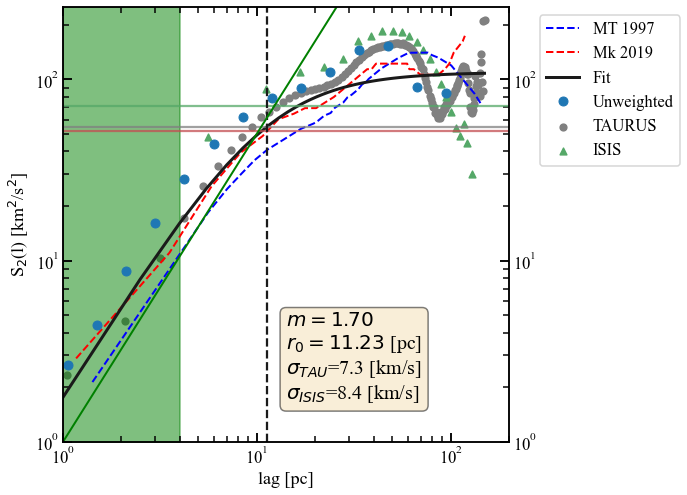

In [83]:
fig, ax=plt.subplots(figsize=(8,8))


plt.loglog(dtx['pc'],dtx['S'],linestyle='--',color='blue',linewidth=2,label='MT 1997')

plt.loglog(dtx['pc.1'],dtx['S.1'],linestyle='--',color="red",linewidth=2,label='Mk 2019')

plt.scatter(T['pc'],T['S'], marker='o',color="gray",s=45,label='TAURUS')
plt.scatter(I['pc'],I['S'], marker='^',color='g',s=45,label='ISIS')

ss=7.39**2
lo=11.23

n=1.7

x=np.linspace(int(T.pc.min()),int(T.pc.max()),100)
c=1/(1+(x/lo)**n)

y=2*(1-c)*ss

plt.loglog(x,y,color='k', linestyle='-',label='Fit',linewidth=3)

plt.axhline(7.39**2, color="gray", linestyle='-', alpha=0.75)
plt.axhline(8.42**2, color='g', linestyle='-', alpha=0.75)
plt.axhline(7.2**2, color='r', linestyle='-', alpha=0.75)

#plt.title('Comparación NGC 604')

ax.set_xlim(1, 200)
ax.set_ylim(1, 250)

ax.set(xlabel='lag [pc]', ylabel='S$_{2}$(l) [km$^{2}$/s$^{2}$]')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)

ax.plot(r, B, 'o', label="Unweighted")


#plt.legend(loc='lower right')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="21"

textstr = '\n'.join((r'$m=%.2f$'%+n, r'$r_{0}=%.2f$' % lo+' [pc]',
                     r'$σ_{TAU}$=7.3 [km/s]',r'$σ_{ISIS}$=8.4 [km/s]')) 

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.5, .3, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

xs=np.linspace(1,4,10)
ys=np.linspace(1,4,10)

ax.fill_between(xs, 0, 1, where=ys > 0.5,
                color='green', alpha=0.5, transform=ax.get_xaxis_transform())

plt.axvline(x=lo, color='k', linestyle='--')

sgrid = np.logspace(0, 2.0)
ax.plot(sgrid, 1*sgrid**(1.7), color="green", lw=2)

fig.savefig('SF604.pdf', bbox_inches='tight')

PDF/CDF

In [45]:
sb /= np.nanmean(sb)

In [46]:
header=0

In [47]:
input_data = (sb, header) 

In [48]:
pdf_mom0 = tss.PDF(input_data, min_val=0.0, bins=None)

Optimization terminated successfully.
         Current function value: 1.523065
         Iterations: 21
         Function evaluations: 42
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:                -8414.9
Model:                     Likelihood   AIC:                         1.684e+04
Method:            Maximum Likelihood   BIC:                         1.686e+04
Date:                Wed, 05 May 2021                                         
Time:                        10:08:55                                         
No. Observations:                5525                                         
Df Residuals:                    5523                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

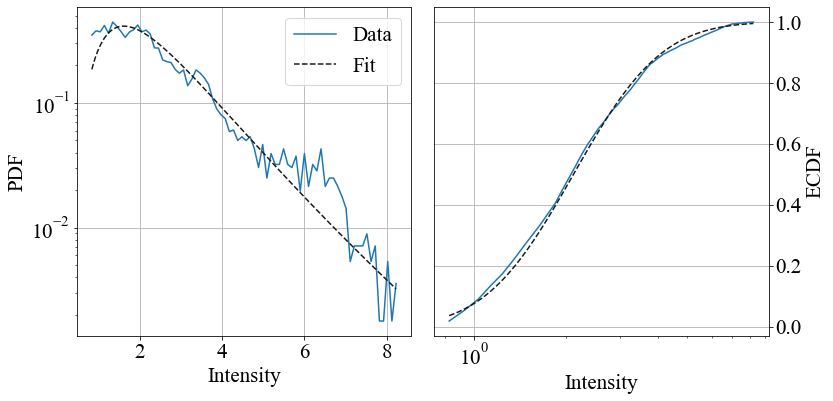

In [49]:
plt.figure(figsize=(12, 6))
pdf_mom0.run(verbose=True)

In [50]:
from scipy.stats import lognorm
import seaborn as sns
sns.set_color_codes()
sns.set_context("talk")

In [51]:
LN = lognorm(s=1.0, scale=np.exp(1.0))

[None]

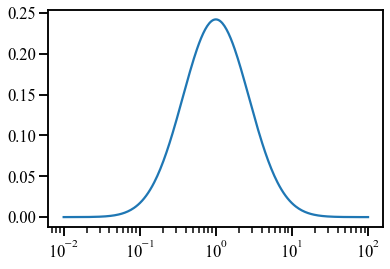

In [52]:
x = np.logspace(-2.0, 2.0, 300)
fig, ax = plt.subplots()
ax.plot(x, LN.pdf(x))
ax.set(xscale="log")

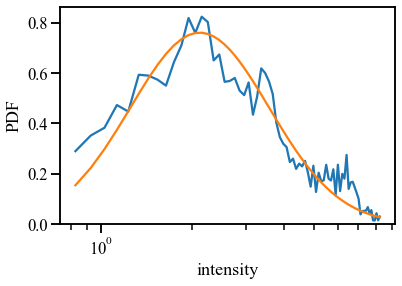

In [53]:
fig, ax = plt.subplots()
s, scale = pdf_mom0.model_params
LN = lognorm(s=s, scale=scale)
x = pdf_mom0.bins
ax.plot(x, x*pdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    ylim=[0, None],
);

In [54]:
pdf_mom0.model_params

array([0.52497263, 2.11390153])

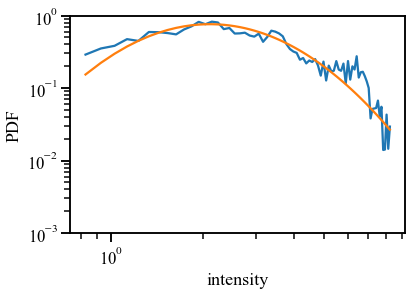

In [55]:
fig, ax = plt.subplots()
ax.plot(x, x*pdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    yscale="log",
    ylim=[1e-3, 1.0],
);

Optimization terminated successfully.
         Current function value: 2.964747
         Iterations: 24
         Function evaluations: 49
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:                -16380.
Model:                     Likelihood   AIC:                         3.277e+04
Method:            Maximum Likelihood   BIC:                         3.279e+04
Date:                Wed, 05 May 2021                                         
Time:                        10:08:57                                         
No. Observations:                5525                                         
Df Residuals:                    5523                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

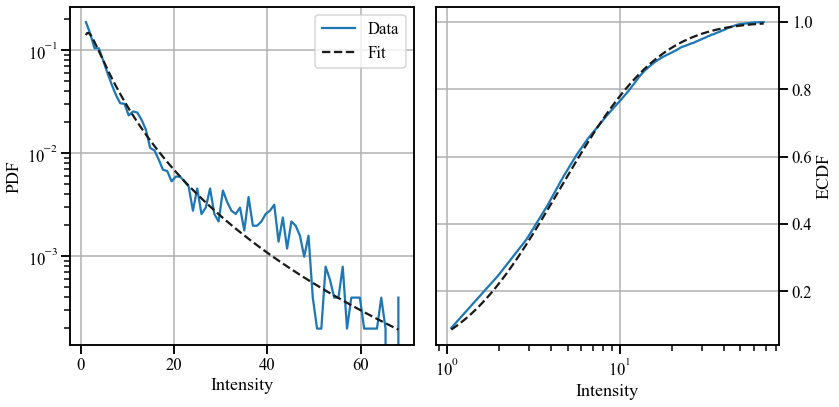

In [56]:
wpdf_mom0 = tss.PDF(input_data, min_val=0.0, weights=sb)
plt.figure(figsize=(12, 6))
wpdf_mom0.run(verbose=True)

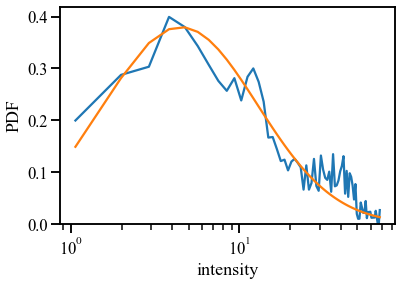

In [57]:
fig, ax = plt.subplots()
s, scale = wpdf_mom0.model_params
LN = lognorm(s=s, scale=scale)
x = wpdf_mom0.bins
ax.plot(x, x*wpdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    ylim=[0, None],
);

In [58]:
wpdf_mom0.model_params

array([1.04994526, 4.46857969])

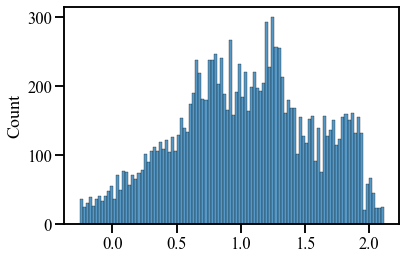

In [59]:
m = np.isfinite(sb) & (sb > 0.0)
sns.histplot(x=np.log(sb[m]), kde=False, weights=sb[m].astype(float), bins=100)

In [60]:
H, edges = np.histogram(np.log(sb[m]), weights=sb[m], bins=100, range=[-4.0, 2.5], density=True)

[Text(0, 0.5, 'PDF'), Text(0.5, 0, '$\\ln (S/S_0)$')]

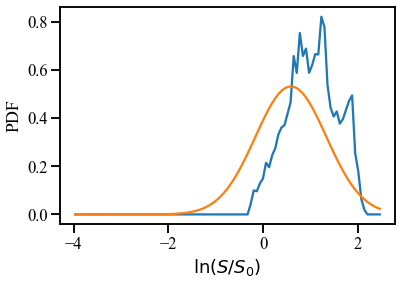

In [61]:
fig, ax = plt.subplots()
centers = 0.5*(edges[:-1] + edges[1:])
ax.plot(centers, H)
LN = lognorm(s=0.75,scale=1.8)
ax.plot(centers, np.exp(centers)*LN.pdf(np.exp(centers)))
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="PDF",
#    yscale="log",
#    ylim=[1e-3, 1.0],
)

[Text(0, 0.5, 'CDF'), Text(0.5, 0, '$\\ln (S/S_0)$')]

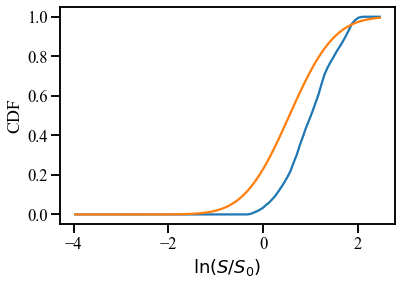

In [62]:
cdf = np.cumsum(H)*(centers[1] - centers[0])
fit = np.exp(centers)*LN.pdf(np.exp(centers))
cdf_fit = np.cumsum(fit)*(centers[1] - centers[0])

fig, ax = plt.subplots()
ax.plot(centers, cdf)
ax.plot(centers, cdf_fit)
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="CDF",
#    yscale="log",
#    ylim=[1e-3, 1.0],
)

[None,
 (0.0003333333333333333, 3000.0),
 Text(0, 0.5, 'CDF / (1 $-$ CDF)'),
 Text(0.5, 0, '$\\ln (S/S_0)$')]

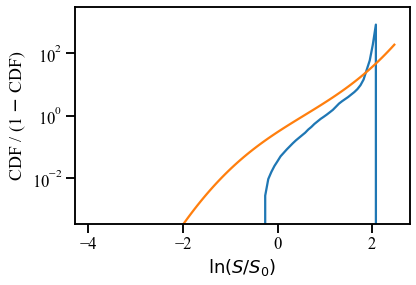

In [63]:
fig, ax = plt.subplots()
ax.plot(centers, cdf/(1 - cdf))
ax.plot(centers, cdf_fit/(1 - cdf_fit))
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="CDF / (1 $-$ CDF)",
    yscale="log",
    ylim=[1e-3/3, 3e3],
)

Spatial Power Spectrum

In [64]:
#pspec = tss.PowerSpectrum(input_data)

In [65]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 134.01277375221252 seconds ---
